# Load dataset

In [1]:
import sys
from pathlib import Path

# Add parent directory to path to allow importing from core/
# Make sure we can import from core/
root_path = Path.cwd().parent
sys.path.insert(0, str(root_path))

# Import core neural network components and other required libraries
from core import *
# Import Libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# Data preprocessing and evaluation utilities

In [2]:
#  Data 
def standardize(X):
    """Standardize features by removing mean and scaling to unit variance"""
    return (X - X.mean(axis=0)) / (X.std(axis=0) + 1e-8)

def accuracy(logits, y_true):
    """Calculate classification accuracy from logits and true labels"""
    pred = np.argmax(logits, axis=1)
    return float(np.mean(pred == y_true))

# Create and split dataset

In [3]:
X, y = Spiral(n_points=200, n_classes=3, n_dimensions=2).generate()
X = standardize(X)  # Standardize features
X_tr, X_val, y_tr, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

# Define neural network architecture:
model = NeuralNetwork()
model.add_layer(Linear(2, 128, init_type='he'))
model.add_layer(ReLULayer())
model.add_layer(Linear(128, 64, init_type='he'))
model.add_layer(ReLULayer())
model.add_layer(Linear(64, 3, init_type='xavier'))

# Define loss function and optimizer
loss_fn = SoftmaxCrossEntropyLoss()  # Suitable for multi-class classification
optimizer = Adam(learning_rate=1e-3)  # Adaptive momentum optimizer

# Training loop configuration

In [4]:
epochs = 1000  # Total training epochs
batch_size = 64  # Samples per batch
hist_loss, hist_acc, hist_val = [], [], []  # Track training history

for ep in range(1, epochs + 1):
    ep_loss, ep_correct, ep_total, batches = 0.0, 0, 0, 0

    # Mini-batch training
    for xb, yb in batch_iterator(X_tr, y_tr, batch_size=batch_size, shuffle=True):
        # Forward pass
        logits = model.forward(xb)
        loss = loss_fn.forward(logits, yb)
        ep_loss += loss
        ep_correct += np.sum(np.argmax(logits, axis=1) == yb)
        ep_total += yb.size

        # Backward pass
        grad = loss_fn.backward()
        model.backward(grad)

        # Update parameters
        model.update_params(optimizer)
        model.zero_grad()  # Reset gradients
        batches += 1

    # Calculate epoch metrics
    tr_loss = ep_loss / max(1, batches)
    tr_acc = ep_correct / max(1, ep_total)

    # Validation evaluation
    model.eval()
    val_logits = model.forward(X_val)
    val_acc = accuracy(val_logits, y_val)
    model.train()

    # Store history for plotting
    hist_loss.append(tr_loss)
    hist_acc.append(tr_acc)
    hist_val.append(val_acc)

    # Print progress every 20 epochs
    if ep == 1 or ep % 20 == 0:
        print(f"Epoch {ep:03d}/{epochs} | loss={tr_loss:.4f} | acc={tr_acc:.4f} | val_acc={val_acc:.4f}")

Epoch 001/1000 | loss=0.9680 | acc=0.3771 | val_acc=0.6417
Epoch 020/1000 | loss=0.1381 | acc=0.9833 | val_acc=0.9750
Epoch 040/1000 | loss=0.0484 | acc=0.9958 | val_acc=0.9917
Epoch 060/1000 | loss=0.0336 | acc=0.9979 | val_acc=0.9750
Epoch 080/1000 | loss=0.0235 | acc=0.9979 | val_acc=0.9750
Epoch 100/1000 | loss=0.0202 | acc=0.9958 | val_acc=0.9750
Epoch 120/1000 | loss=0.0173 | acc=0.9979 | val_acc=0.9833
Epoch 140/1000 | loss=0.0161 | acc=0.9979 | val_acc=0.9833
Epoch 160/1000 | loss=0.0145 | acc=0.9958 | val_acc=0.9833
Epoch 180/1000 | loss=0.0124 | acc=0.9958 | val_acc=0.9917
Epoch 200/1000 | loss=0.0115 | acc=0.9979 | val_acc=0.9833
Epoch 220/1000 | loss=0.0116 | acc=0.9979 | val_acc=0.9833
Epoch 240/1000 | loss=0.0123 | acc=0.9958 | val_acc=0.9833
Epoch 260/1000 | loss=0.0092 | acc=0.9979 | val_acc=0.9833
Epoch 280/1000 | loss=0.0090 | acc=0.9979 | val_acc=0.9833
Epoch 300/1000 | loss=0.0086 | acc=0.9979 | val_acc=0.9833
Epoch 320/1000 | loss=0.0082 | acc=0.9979 | val_acc=0.98

# Plot training history

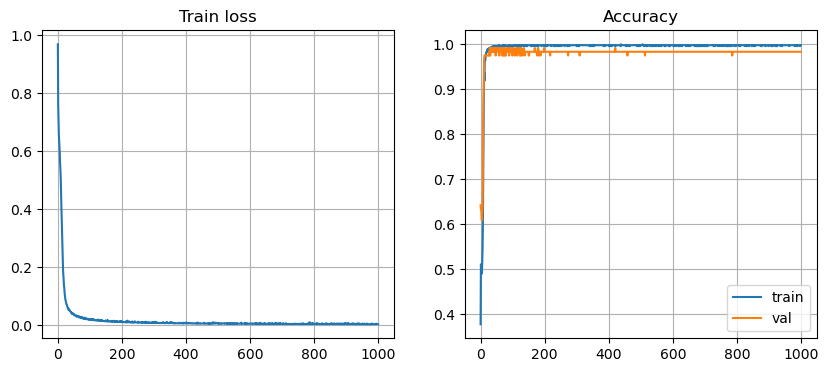

In [5]:
#  Plots 
plt.figure(figsize=(10,4))
plt.subplot(1,2,1); plt.plot(hist_loss); plt.title("Train loss"); plt.grid(True)
plt.subplot(1,2,2); plt.plot(hist_acc, label="train"); plt.plot(hist_val, label="val"); 
plt.title("Accuracy"); plt.legend(); plt.grid(True)
plt.show()

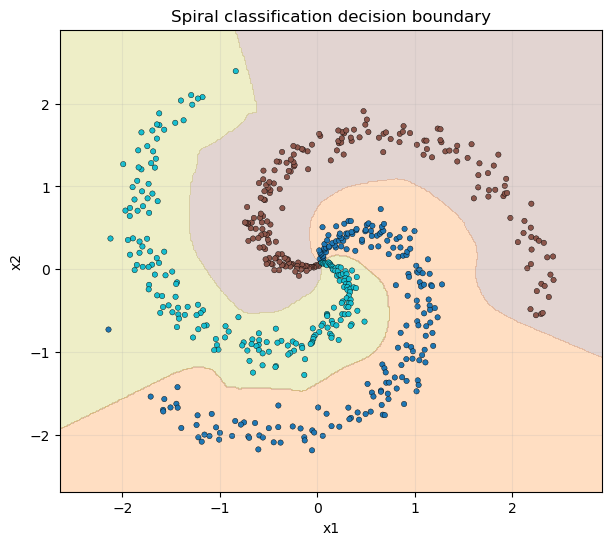

In [6]:
# Visualize decision boundaries
# Decision boundary
x_min, x_max = X[:,0].min()-0.5, X[:,0].max()+0.5
y_min, y_max = X[:,1].min()-0.5, X[:,1].max()+0.5
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 400),
                     np.linspace(y_min, y_max, 400))
grid = np.c_[xx.ravel(), yy.ravel()]  # Create grid for prediction

model.eval()
Z = np.argmax(model.forward(grid), axis=1).reshape(xx.shape)  # Predict class for each grid point

# Plot decision boundaries and data points
plt.figure(figsize=(7,6))
plt.contourf(xx, yy, Z, alpha=0.25, levels=np.arange(0,4)-0.5, cmap="tab10")
plt.scatter(X[:,0], X[:,1], c=y, s=15, cmap="tab10", edgecolors='k', linewidths=0.3)
plt.title("Spiral classification decision boundary"); plt.xlabel("x1"); plt.ylabel("x2")
plt.grid(True, alpha=0.2)
plt.show()

In [7]:
# Save model
filepath = root_path / 'models' / 'spiral_model.pkl'
save_checkpoint(model, optimizer, filepath)